In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# Set plot size
plt.rcParams['figure.figsize'] = [16, 16]

In [285]:
filePath = 'data/fullTraces.csv'
data = pd.read_csv(filePath, header=0)

In [286]:
data.drop(columns=['SeqNumber', 'run'], inplace=True)
# Data cleanup (nan non unique samples removal)
#data = data.dropna()
print(f"Data shape after dropping NaN values: {data.shape}")
data = data.drop_duplicates()
print(f"Data shape after dropping duplicates: {data.shape}")

# Rescale "LineLoading_x" features to decimal % (just dividig by 100)
line_loading_cols = data.filter(regex="LineLoading_[0-9]+").columns
data[line_loading_cols] = data[line_loading_cols].div(100)

# Add a new feature "PercOverLines" as the percentage of overloaded lines (computed based on LineLoading_x > 100)
data['PercOverloadedLines'] = (data.filter(regex="LineLoading_[0-9]+", axis=1) > 1).sum(axis=1) / data.filter(regex="LineLoading_[0-9]+", axis=1).shape[1]
# Add a new feature "PercOutOfSpecBusses" as the percentage of out-of-spec busses (computed based on BusVoltage_x < 0.95 or BusVoltage_x > 1.05)
data['PercOutOfSpecBusses'] = (data.filter(regex="BusVoltage_[0-9]+", axis=1).lt(0.95) | data.filter(regex="BusVoltage_[0-9]+", axis=1).gt(1.05)).sum(axis=1) / data.filter(regex="BusVoltage_[0-9]+", axis=1).shape[1]

data.head()

Data shape after dropping NaN values: (400, 60)
Data shape after dropping duplicates: (400, 60)


,BusVoltage_0,BusVoltage_1,BusVoltage_10,BusVoltage_11,BusVoltage_12,BusVoltage_13,BusVoltage_14,BusVoltage_2,BusVoltage_3,BusVoltage_4,...,BusCycles_0,NumCycles,PercNodesInCycles,MeanCycleLength,MaxCycleLength,MinCycleLength,Load,Generation,PercOverloadedLines,PercOutOfSpecBusses
0,1.03,0.992323,0.980487,0.980341,0.997577,0.993440,0.991063,0.987415,0.979403,0.977613,...,0,0,0.0,0.0,0,0,1.21,2.16,0.133333,0.0
1,1.03,0.992325,0.980500,0.980353,0.997579,0.993443,0.991066,0.987421,0.979414,0.977625,...,0,0,0.0,0.0,0,0,1.21,2.16,0.133333,0.0
2,1.03,0.992326,0.980508,0.980362,0.997580,0.993445,0.991069,0.987425,0.979422,0.977633,...,0,0,0.0,0.0,0,0,1.21,2.16,0.133333,0.0
3,1.03,0.992327,0.980516,0.980370,0.997581,0.993447,0.991071,0.987429,0.979429,0.977641,...,0,0,0.0,0.0,0,0,1.21,2.16,0.133333,0.0
4,1.03,0.992317,0.980483,0.980337,0.997583,0.993449,0.991073,0.987409,0.979395,0.977604,...,0,0,0.0,0.0,0,0,1.21,2.16,0.133333,0.0


<AxesSubplot:>

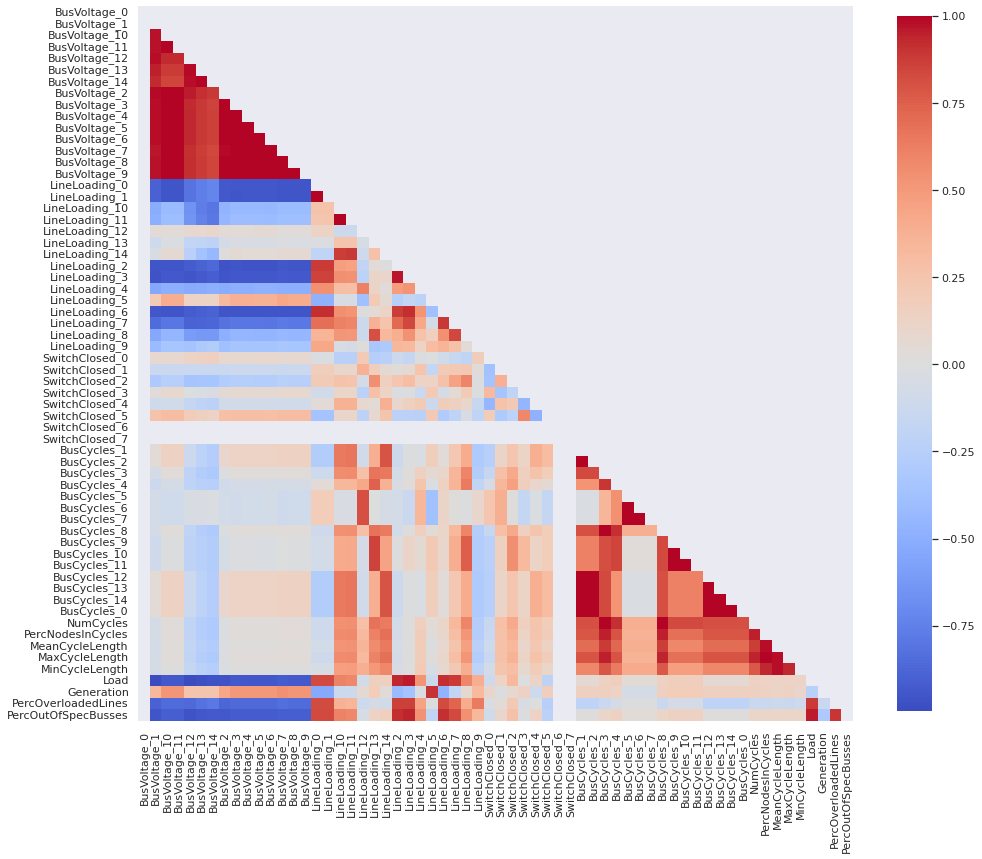

In [287]:
# Feature correlation analysis
corr = data.corr()
# Display the correlation matrix as heatmap (only half visualized)
sns.heatmap(corr, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, mask=np.triu(corr))

In [294]:
# Perform Recursive Feature Elimination with Random Forest as backend model
minFeat = 1
clf = RandomForestRegressor()
cv = KFold(n_splits=5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    scoring="explained_variance",
    cv=cv,
    verbose=True,
    min_features_to_select=minFeat,
    n_jobs=8,
)

lineLoadingCols = data.filter(regex="LineLoading_[0-9]+").columns
busVoltageCols = data.filter(regex="BusVoltage_[0-9]+").columns
X = data.drop(columns=["PercOverloadedLines", "PercOutOfSpecBusses"] + list(lineLoadingCols) + list(busVoltageCols))
Y = data["PercOverloadedLines"]

rfecv.fit(X, Y)

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 fe

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

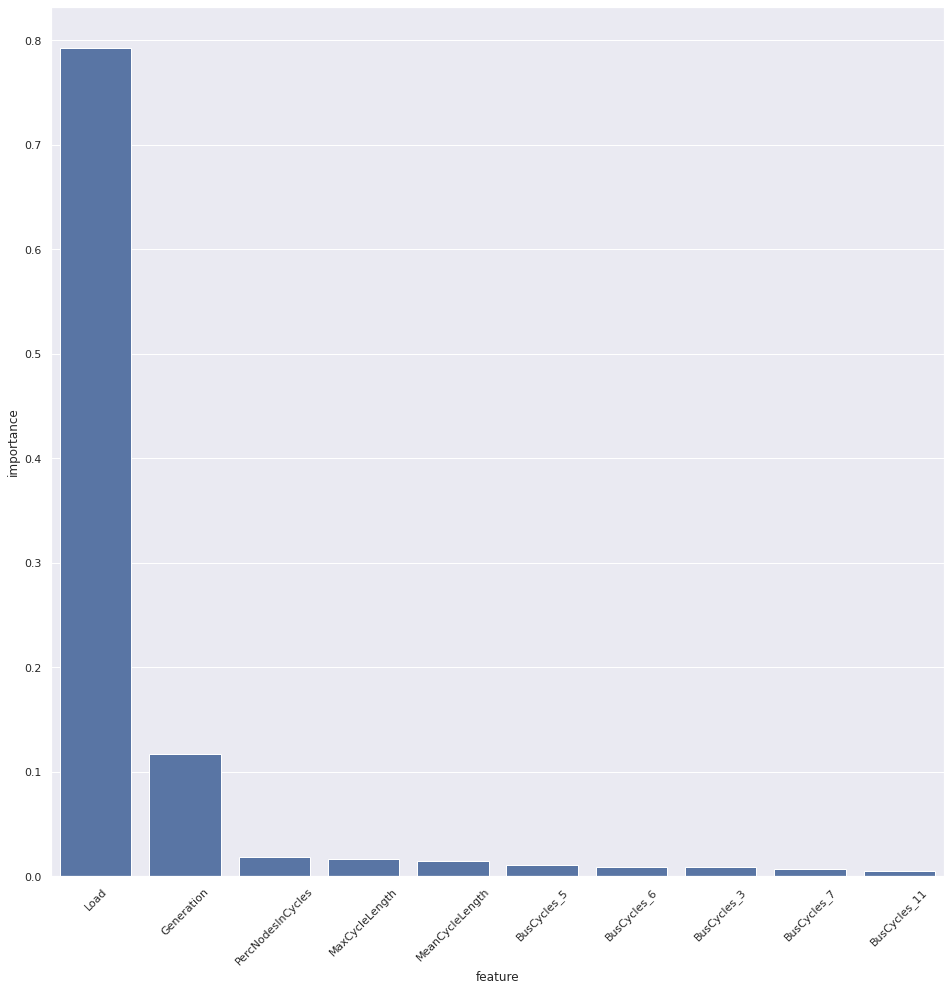

In [295]:
selFeat = pd.DataFrame(columns=["feature", "importance"])
i = 0
for selFeatIdx, col in zip(rfecv.support_, X.columns):
    if selFeatIdx:
        selFeat.loc[len(selFeat)] = {"feature": col, "importance": rfecv.estimator_.feature_importances_[i]}
        i += 1

selFeat.sort_values(by="importance", inplace=True, ascending=False)
selFeat.reset_index(inplace=True)


barPlot = sns.barplot(data=selFeat, x="feature", y="importance")
plt.xticks(rotation=45)

[0.45045812 0.71398519 0.77402358 0.83465768 0.82914937 0.82629749
 0.83017859 0.83183433 0.83546015 0.8413348  0.82841203 0.81068257
 0.83387368 0.82992974 0.81689822 0.82897788 0.81587384 0.8302364
 0.81742105 0.81789664 0.80917133 0.82212701 0.82329641 0.82340412
 0.81670578 0.80851644 0.81803236 0.82492528 0.82321119 0.83156567]


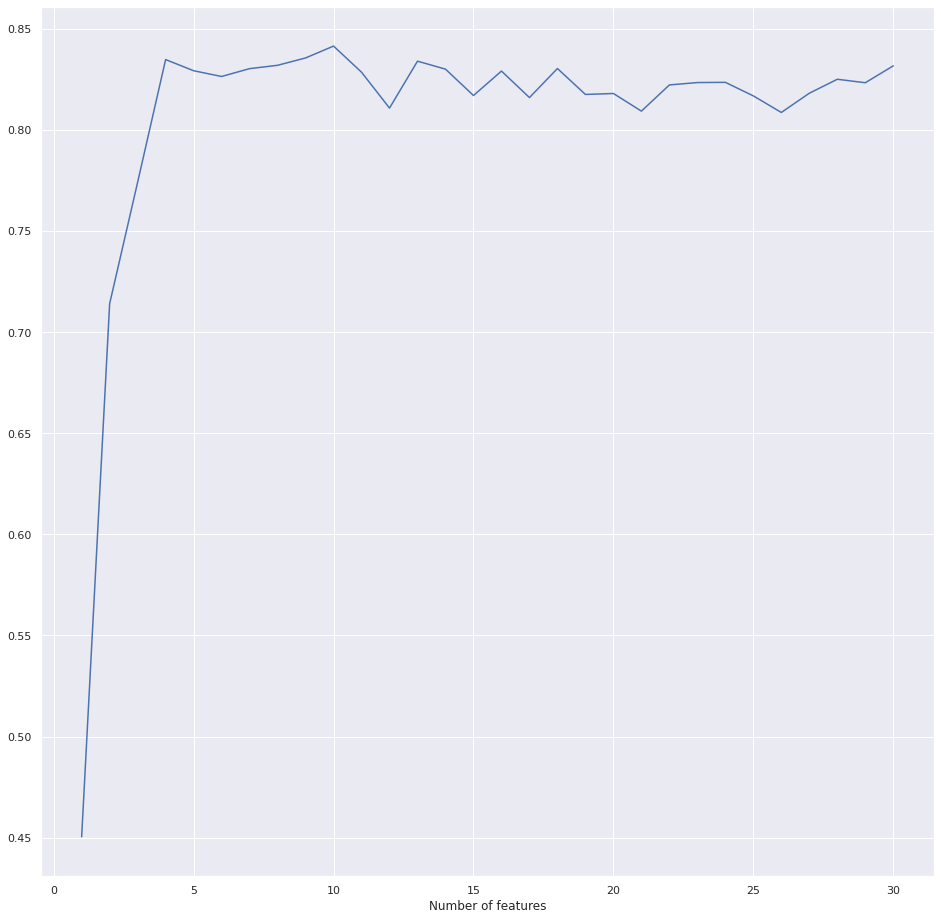

In [296]:
testScores = rfecv.cv_results_["mean_test_score"]
scoresPlot = sns.lineplot(x=rfecv.cv_results_["n_features"], y=testScores)
scoresPlot.set_xlabel("Number of features")
print(testScores)